In [1]:
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt
import numpy as np 
import pickle
from numpy import pi, sin
import operator

creator.create("obj", base.Fitness, weights=(-1.0,))

creator.create("Ind", list, fitness=creator.obj)

In [2]:
checkpoint_file = "checkpoint.pkl"
with open(checkpoint_file, "rb") as cp_file:
    cp = pickle.load(cp_file)

In [3]:
cp["input_file"]

{'control_variables': {'sine_a_x': {'min': 0.0, 'max': 2.0},
  'sine_b_x': {'min': 0.0, 'max': 1.57},
  'sine_c_x': {'min': 0.0, 'max': 6.28},
  'sine_a_y': {'min': 0.0, 'max': 2.0},
  'sine_b_y': {'min': 0.0, 'max': 1.57},
  'sine_c_y': {'min': 0.0, 'max': 6.28}},
 'evaluators': {'openmc': {'order': 0,
   'input_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc.py'],
   'execute': [['aprun -n 1 -d 64 --env OMP_NUM_THREADS=64 openmc-0.12.2'],
    ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ../../../../../moltres/python/moltres_xs.py',
     'fhr_assem_gc.inp']],
   'inputs': ['sine_a_x',
    'sine_b_x',
    'sine_c_x',
    'sine_a_y',
    'sine_b_y',
    'sine_c_y'],
   'output_script': ['aprun -n 1 -d 1 --env OMP_NUM_THREADS=1 python ',
    'fhr_assem_openmc_output.py'],
   'outputs': ['keff']},
  'moltres': {'order': 1,
   'input_script': ['aprun -n 64 -N 64 -d 1 -j 1 moltres-opt -i ',
    'fhr_assem_moltres.i'],
   'execute': [],
   'inputs': [],

In [4]:
def get_ind_list(pop_list, index):
    ind_list = [] 
    for pop in pop_list:
        ind_list.append(pop[index])
    return ind_list

In [5]:
logbook = cp["logbook"]

In [6]:
def plot_1_obj(logbook, index, obj_name, short_name, save_fig, save_fig_title):
    gen = np.array(logbook.select("gen"))+1
    obj_avg = get_ind_list(logbook.chapters["oup"].select("avg"), index)
    obj_std = get_ind_list(logbook.chapters["oup"].select("std"), index)
    obj_min = get_ind_list(logbook.chapters["oup"].select("min"), index)
    obj_max = get_ind_list(logbook.chapters["oup"].select("max"), index)
    plt.rc('font', family='serif')
    fig, ax = plt.subplots(figsize=(7,7))
    ax.errorbar(gen, obj_avg, yerr=obj_std, label="Ave "+ short_name, capsize=5)
    ax.plot(gen, obj_min, "*-", label="Min "+ short_name)
    ax.plot(gen, obj_max, "*-", label="Max "+ short_name)
    ax.set_xlabel("Generation [#]", fontsize=22)
    ax.set_ylabel(obj_name + " ("+short_name+") [K]", fontsize=22)
    ax.tick_params(axis='both', which='major', labelsize=16)
    ax.set_xticks([1,2,3])
    ax.grid()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, fontsize=22, bbox_to_anchor = [1.0, 1.0])
    ax.set_title("One-Third Assembly $T_{max}$ Evolution", fontsize=24)
    if save_fig:
        plt.savefig(save_fig_title,bbox_inches='tight')

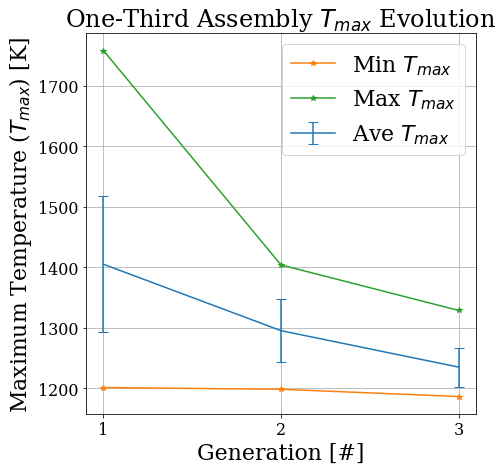

In [7]:
plot_1_obj(logbook, 0, "Maximum Temperature", "$T_{max}$", True, "assem-obj-1-temp-evol-pres.png")

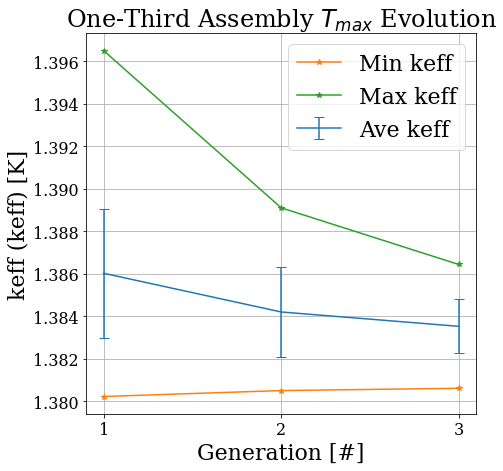

In [8]:
plot_1_obj(logbook, 1, "keff", "keff", False, "")

In [9]:
midpoints_discr_x = np.array([ 6.18871652,  8.22745601, 10.2661955,  12.304935,  14.34367449, 16.38241398,
 18.42115347, 20.45989297, 22.49863246, 24.53737195])
midpoints_discr_y = np.array([19.775, 16.525, 13.275, 10.025,  6.775,  3.525])
def calc_pf_distr(ind, pf_present):
    if pf_present:
        total_pf, sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5], ind[6]
    else:
        sine_a_x, sine_b_x, sine_c_x, sine_a_y, sine_b_y, sine_c_y = ind[0], ind[1], ind[2], ind[3], ind[4], ind[5]
        total_pf = 0.06
    sine_val_discr_x = sine_a_x * sin(sine_b_x * midpoints_discr_x + sine_c_x) + 2
    sine_val_discr_y = sine_a_y * sin(sine_b_y * midpoints_discr_y + sine_c_y) + 2
    sine_val_distr_xy = sine_val_discr_y.reshape(6,1) * sine_val_discr_x.reshape(1,10) 
    vol_triso = 0.0003181623994807103
    vol_total = 419.3793150536547
    vol_slice = 6.989655250894246
    no_trisos = total_pf * vol_total / vol_triso
    triso_distr = sine_val_distr_xy / sum(sum(sine_val_distr_xy)) * no_trisos
    pf_distr = triso_distr * vol_triso / vol_slice
    return pf_distr

2 41 (1186.5019729594, 1.3808499388750444)
std 0.0009
max, min 0.0622 0.0586
2 24 (1186.9554008159, 1.3838274493908176)
std 0.0017
max, min 0.0639 0.0575
2 30 (1189.230487534, 1.38400308402678)
std 0.0027
max, min 0.0647 0.0554
1 23 (1198.4558293499, 1.3835238153463956)
std 0.004
max, min 0.0673 0.0533


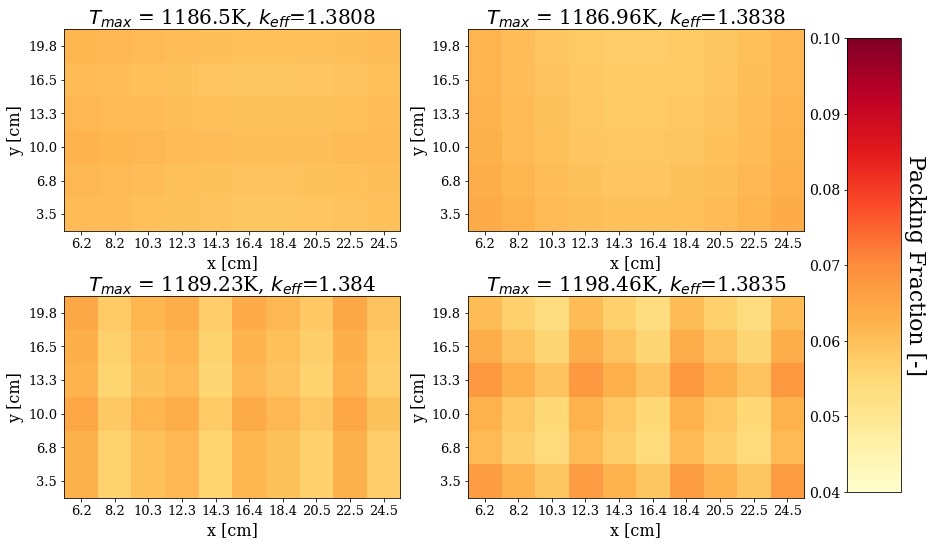

In [14]:
midpoints_discr_x_rounded = [ '%.1f' % elem for elem in midpoints_discr_x]
midpoints_discr_y_rounded = [ '%.1f' % elem for elem in midpoints_discr_y]
results = cp["all"]
pop = results["populations"][-1]
oup_results = results["outputs"][-1]
obj_0 = np.array([item[0] for item in oup_results])
sorted_index_0 = np.argsort(obj_0)
fig, axes = plt.subplots(figsize=(15,9), nrows=2, ncols=2)
count = 0
old_ppf = 0
for i in sorted_index_0[:128]:
    ind = pop[i]
    new_ppf = round(ind.output[0], 3)
    if new_ppf != old_ppf:
        print(ind.gen, ind.num, ind.output)
        #print(new_ppf)
        #print(ind)
        old_ppf = new_ppf
        ax = axes.flat[count]
        count += 1
        pf_distr = calc_pf_distr(ind, False)
        im = ax.imshow(pf_distr, vmin=0.04, vmax=0.1,cmap="YlOrRd")
        print("std", round(np.std(pf_distr),4))
        print("max, min", round(np.amax(pf_distr),4), round(np.amin(pf_distr),4))
        ax.set_title("$T_{max}$ = "+str(round(oup_results[i][0],2)) + "K, $k_{eff}$=" + str(round(oup_results[i][1],4)), fontsize=20)
        ax.set_xlabel("x [cm]", fontsize=16)
        ax.set_ylabel("y [cm]", fontsize=16)
        ax.tick_params(axis='both', which='major', labelsize=13)
        ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
        ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
        if count == 4:
            break
fig.subplots_adjust(right=0.81)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=25)
plt.savefig("assem-obj-1-temp-final.png",bbox_inches='tight')

0.06177102681844139 0.059598655985514615
0.06076986089026028 0.058632699180013174
0.061380824906535715 0.05922217674095051
0.0621656037856074 0.059979356422874275
0.06127669216305399 0.05912170615020192
0.06080674191185469 0.05866828316544478


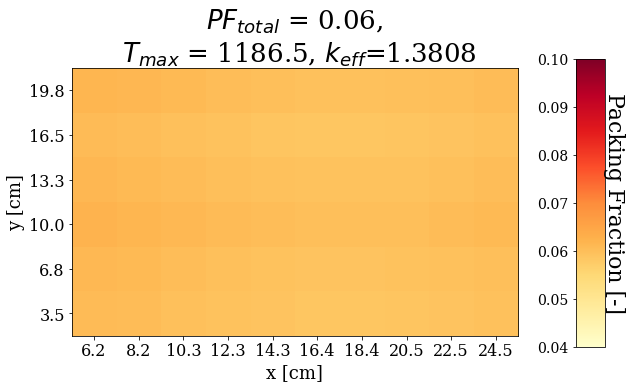

In [11]:
temp_most_minimized = pop[sorted_index_0[0]]
pf_distr = calc_pf_distr(temp_most_minimized, False)
#print(pf_distr)
for row in pf_distr:
    #print(np.max(row)- np.min(row))
    print(np.max(row), np.min(row))
#for i in range(10):
#    col = pf_distr[:, i]
 #   print(np.max(col)-np.min(col))
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(pf_distr, vmin=0.04, vmax=0.1,cmap="YlOrRd")
ax.set_title("$PF_{total}$ = 0.06" + ",\n $T_{max}$ = "+str(round(temp_most_minimized.output[0],2))
             + ", $k_{eff}$=" + str(round(temp_most_minimized.output[1],4)), fontsize=26)
ax.set_xlabel("x [cm]", fontsize=18)
ax.set_ylabel("y [cm]", fontsize=18)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded, fontsize=16)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded, fontsize=16)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=22, rotation=270, labelpad=20)
plt.savefig("a-1b-temp-most-minimized.png",bbox_inches='tight')

2 41
[0.04017277560563537, 0.2100659950942994, 0.9416345067098484, 0.023201228496242843, 0.538099007307603, 2.385264603218885]
0.06177102681844139 0.059598655985514615
0.06076986089026028 0.058632699180013174
0.061380824906535715 0.05922217674095051
0.0621656037856074 0.059979356422874275
0.06127669216305399 0.05912170615020192
0.06080674191185469 0.05866828316544478


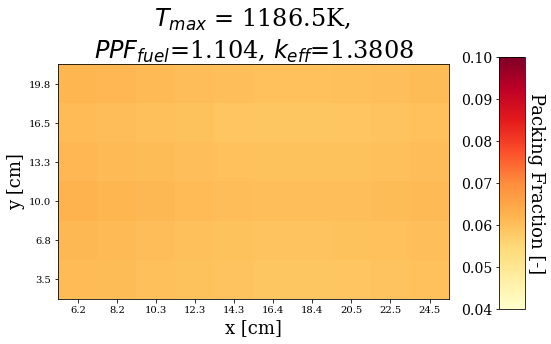

In [12]:
temp_most_minimized = pop[sorted_index_0[0]]
pf_distr = calc_pf_distr(temp_most_minimized, False)
#print(pf_distr)
print(temp_most_minimized.gen, temp_most_minimized.num)
print(temp_most_minimized)
for row in pf_distr:
    #print(np.max(row)- np.min(row))
    print(np.max(row), np.min(row))
#for i in range(10):
#    col = pf_distr[:, i]
 #   print(np.max(col)-np.min(col))
fig, ax = plt.subplots(figsize=(7,7))
im = ax.imshow(pf_distr, vmin=0.04, vmax=0.1,cmap="YlOrRd")
ax.set_title("$T_{max}$ = "+str(round(temp_most_minimized.output[0],2))+ "K, \n$PPF_{fuel}$=1.104" + ", $k_{eff}$=" 
             + str(round(temp_most_minimized.output[1],4)), fontsize=24)
ax.set_xlabel("x [cm]", fontsize=18)
ax.set_ylabel("y [cm]", fontsize=18)
ax.set_xticks(ticks=np.arange(0,10,1),labels=midpoints_discr_x_rounded)
ax.set_yticks(ticks=np.arange(0,6,1), labels=midpoints_discr_y_rounded)
cbar_ax = fig.add_axes([1.0, 0.25, 0.05, 0.5])
cb = fig.colorbar(im, cax=cbar_ax)
cbar_ax.yaxis.set_ticks_position('left')
cbar_ax.tick_params(labelsize=14) 
cb.set_label("Packing Fraction [-]", fontsize=18, rotation=270, labelpad=20)
plt.savefig("a-1b-temp-most-minimized-with-ppf.png",bbox_inches='tight')
